# Central Alps - Trentino download

We want to cover the rectangle Basel-Bard-Trento-Innsbruck
aka `[[[7.734,45.583], [11.249,45.583], [11.249,47.517], [7.734, 47.517], [7.734,45.583]]]`.

The output of this notebook should be a file `data/dtm_local/trento_dtm.tif`

The issue with Trentino is there are several datasets of varying quality. They cover different areas and have different ways of *not* specifying the projection, which trips gdalbuildvrt.
* `lidar_2009_pat_dtm_1mX1m` & `2mX2m` - covers most of the country ; >2000m has lower 2m resolution.
* `lidar_2011_campolongo_dtm`  - small area
* `lidar_2012_pellizzano_dtm_1mX1m` - tiny area (useless?)
* `lidar_2014_pat_dtm_asc` - covers most of the country **except Campolongo, Brento, and Pampeago**

Also, all datasets before 2014 use a cryptic numbering scheme, so we have to download the whole country twice :-(

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Preamble - Execute only once

%load_ext autoreload
%autoreload 2

import os
NBROOT = os.path.realpath(os.curdir)

In [90]:
# Preamble
from urllib.error import URLError
import time
import logging
logging.basicConfig(level=logging.DEBUG)

# stdlib
import re
from os.path import basename, exists, join as pjoin, realpath
from pathlib import Path
from urllib.request import urlopen, urlretrieve
from zipfile import ZipFile

#external
from IPython.display import Image

# self
from src import bbox, gdal_slope_util as S
# from src.gdal_slope_util import check_run, DFLT_OPT, ZSTD_OPT, TILE_OPT

# CPL_ZIP_ENCODING for gdal vsizip:  https://github.com/conda-forge/gdal-feedstock/issues/83
os.environ['CPL_ZIP_ENCODING'] = 'UTF-8'


In [91]:
TNT_DTM = realpath('data/dtm_final/trentino_dtm.tif')


In [92]:
!mkdir -p data/dtm_local
!mkdir -p data/trentino
%cd data/trentino

/home/me/code/eddy-geek/slope-ign-alti/trentino/data/trentino



[Trentino](https://translate.google.com/?sl=auto&tl=fr&text=http%3A%2F%2Fwww.territorio.provincia.tn.it%2Fportal%2Fserver.pt%2Fcommunity%2Flidar%2F847%2Flidar%2F23954&op=translate)

EPSG:25832

https://siat.provincia.tn.it/stem/services/file?id=116842&token=1d6ktnjsn0qiejfripki8jnj1f8l4kefgo505l7j48chhgkntad67nddmeshfls0rm54e3nmqc6vqv5iah3lth2ebfpt9gqcg0q6t12


## 2014 PAT + Compolongo 2011

In [5]:
# Better: https://siat.provincia.tn.it/IDT/raster/.public/

In [93]:
def downloadall(rooturl, pattern=r'href="([^"]+)"', destdir='dwn', callback=None):
    indexurl = urlopen(rooturl).read().decode()
    suffixes = re.findall(pattern, indexurl)
    print(len(suffixes))
    for i, suff in enumerate(suffixes, 1):
        dest = pjoin(destdir, basename(suff))
        if not exists(dest) and\
                not exists(dest.replace('asc.zip', 'tif')):  # custom lidar14 case
            print(i, "GET ", rooturl+suff)
            try:
                urlretrieve(rooturl+suff, dest)
            except URLError:
                time.sleep(5)
                urlretrieve(rooturl+suff, dest)
            if callback: callback(dest)
        else:
            print(i, "SKIP", rooturl+suff)

In [46]:
rooturl2011 = 'https://siat.provincia.tn.it/IDT/raster/.public/lidar_2011_campolongo_dtm/'
downloadall(rooturl2011, pattern=r'"(dtm\d+\.asc)"')

25


In [13]:
!gdalbuildvrt -overwrite -a_srs EPSG:25832 trento2011.vrt dwn1/dtm*.asc

0...10...20...30...40...50...60...70...80...90...100 - done.


In [30]:
rooturl2012 = 'https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/'
downloadall(rooturl2012, pattern=r'"(DTM_\d+_geo\.tif)"')


16
0 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000370_geo.aux
1 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000370_geo.tif
2 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000371_geo.aux
3 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000371_geo.tif
4 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000415_geo.aux
5 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000415_geo.tif
6 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000416_geo.aux
7 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000416_geo.tif
8 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2012_pellizzano_dtm_1mX1m/DTM_000462_geo.aux
9 GET  https://siat.provincia.tn.it/IDT/ras

In [37]:
!gdalinfo dwn/DTM_000370_geo.tif | rg -v '^    '

Driver: GTiff/GeoTIFF
Files: dwn/DTM_000370_geo.tif
Size is 2000, 2000
Coordinate System is:
BOUNDCRS[
Data axis to CRS axis mapping: 1,2
Origin = (634000.329999999958090,5131999.799999999813735)
Pixel Size = (1.000000000000000,-1.000000000000000)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  634000.330, 5131999.800) ( 10d44'27.19"E, 46d19'41.95"N)
Lower Left  (  634000.330, 5129999.800) ( 10d44'25.13"E, 46d18'37.18"N)
Upper Right (  636000.330, 5131999.800) ( 10d46' 0.68"E, 46d19'40.52"N)
Lower Right (  636000.330, 5129999.800) ( 10d45'58.60"E, 46d18'35.75"N)
Center      (  635000.330, 5130999.800) ( 10d45'12.90"E, 46d19' 8.85"N)
Band 1 Block=2000x1 Type=Float32, ColorInterp=Gray


In [38]:
!gdalbuildvrt -overwrite -a_srs EPSG:25832 trento2012_dtm.vrt dwn/DTM_*_geo.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


## 2014 data

In [11]:
rooturl2014 = 'https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/'

ZSTD6_OPT = '-co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=6 '

def compress(asc_zip):
    """One-by-one tif compression of file, to save space"""
    asc_name = basename(asc_zip)[:-4]
    dest = 'dwn/' + asc_name[:-3] + 'tif'
    src = f'/vsizip/{{{asc_zip}}}/{asc_name}'
    # This needs CPL_ZIP_ENCODING=UTF-8 (it's in the prelude)
    cmd = f'gdal_translate -a_srs EPSG:25832 {S.TILE_OPT} {S.XTIFF_OPT} {ZSTD6_OPT} {src} {dest}'
    print(cmd)
    S.check_run(cmd)
    print(os.path.getsize(asc_zip), '->', os.path.getsize(dest))
    os.remove(asc_zip)

downloadall(rooturl2014, pattern=r'"(5h\d+_DTM.asc.zip)"', callback=compress)
# 25201 files * 2 MB = 50 GB.
# we can gain 50% with online tiff compression with ZSTD_LEVEL=6 & tiled
# 11 hours

25201
0 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612050925_DTM.asc.zip
1 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612050930_DTM.asc.zip
2 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612050935_DTM.asc.zip
3 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550920_DTM.asc.zip
4 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550925_DTM.asc.zip
5 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550930_DTM.asc.zip
6 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550935_DTM.asc.zip
7 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550940_DTM.asc.zip
8 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_asc/5h612550945_DTM.asc.zip
9 SKIP https://siat.provincia.tn.it/IDT/raster/.public/lidar_2014_pat_dtm_as

In [41]:
!gdalinfo dwn/dtm000802.asc

Driver: AAIGrid/Arc/Info ASCII Grid
Files: dwn/dtm000802.asc
Size is 2020, 2020
Origin = (675990.000000000000000,5116010.000000000000000)
Pixel Size = (1.000000000000000,-1.000000000000000)
Corner Coordinates:
Upper Left  (  675990.000, 5116010.000) 
Lower Left  (  675990.000, 5113990.000) 
Upper Right (  678010.000, 5116010.000) 
Lower Right (  678010.000, 5113990.000) 
Center      (  677000.000, 5115000.000) 
Band 1 Block=2020x1 Type=Float32, ColorInterp=Undefined
  NoData Value=-9999


In [15]:
!gdalbuildvrt -a_srs EPSG:25832 -overwrite trento2014_dtm.vrt dwn/*_DTM.tif #dwn1/dtm*.asc // trento2011.vrt 

0...10...20...30...40...50...60...70...80...90...Warning 6: gdalbuildvrt does not support heterogeneous band data type: expected Float32, got Int32. Skipping dwn/5h717551440_DTM.tif
100 - done.


if you see error *gdalbuildvrt does not support heterogeneous band data type: expected Float32, got Int32*, it's because of empty tiles having only nodata=-9999, it's not an issue.

In [26]:
!gdalinfo trento2014_dtm.vrt | tail
# NoData=-9999 correctly picked up.

Origin = (612000.000000000000000,5157500.000000000000000)
Pixel Size = (0.500000000000000,-0.500000000000000)
Corner Coordinates:
Upper Left  (  612000.000, 5157500.000) ( 10d27'40.65"E, 46d33'42.23"N)
Lower Left  (  612000.000, 5059500.000) ( 10d26'17.38"E, 45d40'48.00"N)
Upper Right (  729000.000, 5157500.000) ( 11d59'10.48"E, 46d31'55.45"N)
Lower Right (  729000.000, 5059500.000) ( 11d56'20.54"E, 45d39' 4.43"N)
Center      (  670500.000, 5108500.000) ( 11d12'22.58"E, 46d 6'31.61"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


gdalwarp -overwrite -tr 100 -100 trento2014_dtm.vrt /tmp/tiny.tif
Creating output file that is 1170P x 980L.
Processing trento2014_dtm.vrt [1/1] : 0Using internal nodata values (e.g. -9999) for image trento2014_dtm.vrt.
Copying nodata values from source trento2014_dtm.vrt to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


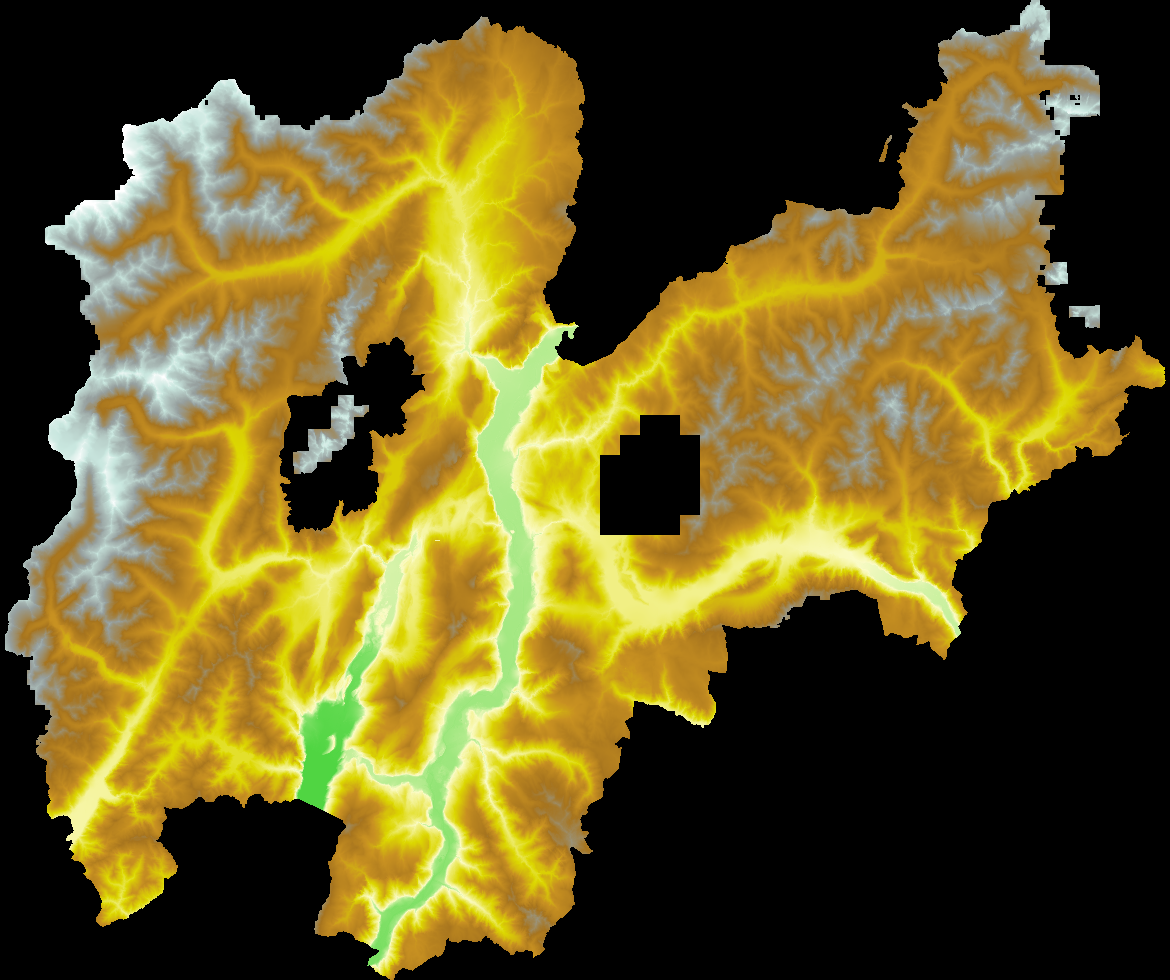

In [27]:
Image(S.relief_tiny('trento2014_dtm.vrt', 100))
# 20 minutes

gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 100 -100 trento2011_dtm.vrt /tmp/tiny.tif
Creating output file that is 100P x 120L.
Processing trento2011_dtm.vrt [1/1] : 0Using internal nodata values (e.g. -9999) for image trento2011_dtm.vrt.
Copying nodata values from source trento2011_dtm.vrt to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


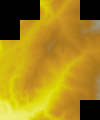

In [ ]:
Image(S.relief_tiny('trento2011_dtm.vrt', 100))

gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 100 -100 trento2012_dtm.vrt /tmp/tiny.tif
Creating output file that is 40P x 80L.
Processing trento2012_dtm.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
Warning 1: Input dataset has no nodata value. Ignoring 'nv' entry in color palette
0...10...20...30...40...50...60...70...80...90...100 - done.


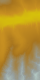

In [ ]:
Image(S.relief_tiny('trento2012_dtm.vrt', 100))

We should have been able to get by with 2011 + + 2012 + 2014 , but because Brento is missing, let's have a look at older data

## 2009 2x2m

2009 was less precise in the high mountains, so let's start with the 2x2 dataset

In [ ]:
# Website found "randomly" via https://geodati.gov.it/geoportalRNDTPA/rest/document?id=p_TN%3A3203e1b3-5d73-47d8-b04e-9ab27c8538cf
!wget https://idt.provincia.tn.it/idt/raster/lidar_2009_pat_dtm_2mX2m/dtm000001_wor.tif

gdaldem slope dtm000001_wor.tif -co COMPRESS=ZSTD -co PREDICTOR=2 -co ZSTD_LEVEL=3 -co TILED=YES -co blockXsize=1024 -co blockYsize=1024 -co BIGTIFF=YES -co SPARSE_OK=TRUE -co NUM_THREADS=ALL_CPUS  /tmp/tiny_slope.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny_slope.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-slope-eslo13near.clr /tmp/tiny_eslo13near.png -nearest_color_entry
0...10...20...30...40...50...60...70...80...90...100 - done.


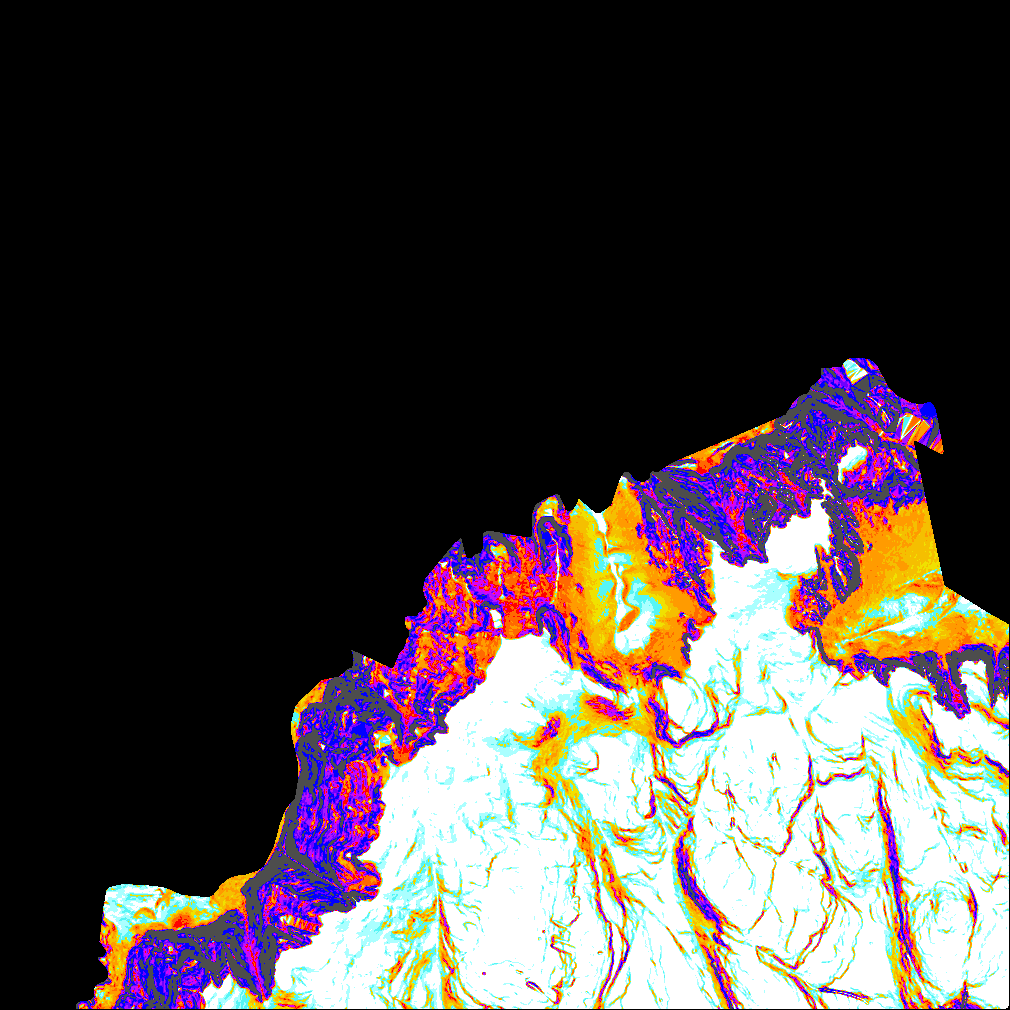

In [86]:
Image(S.eslo_tiny('dtm000001_wor.tif'), height=200)

In [ ]:
import re
!mkdir -p dwn

rooturl2009x2 = 'https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_2mX2m/'
downloadall(rooturl2009x2)

# ~350 files x 0.3 minutes = 2h

In [119]:
# The projection is *not* included in the files!
!gdalbuildvrt -a_srs EPSG:25832 -overwrite trento2009_dtm.vrt dwn/dtm*_wor.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


In [ ]:
!gdalinfo -nofl trento2009x2_dtm.vrt | rg -v '\['

Driver: VRT/Virtual Raster
Files: trento_dtm.vrt
Size is 60010, 49010
Coordinate System is:
Data axis to CRS axis mapping: 1,2
Origin = (611990.000000000000000,5158010.000000000000000)
Pixel Size = (2.000000000000000,-2.000000000000000)
Corner Coordinates:
Upper Left  (  611990.000, 5158010.000) ( 10d27'40.62"E, 46d33'58.76"N)
Lower Left  (  611990.000, 5059990.000) ( 10d26'17.32"E, 45d41' 3.88"N)
Upper Right (  732010.000, 5158010.000) ( 12d 1'32.50"E, 46d32' 8.24"N)
Lower Right (  732010.000, 5059990.000) ( 11d58'40.26"E, 45d39'16.69"N)
Center      (  672000.000, 5109000.000) ( 11d13'33.05"E, 46d 6'46.44"N)
Band 1 Block=128x128 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [ ]:
opt = S.DFLT_OPT
!gdal_translate $opt trento2009_dtm.vrt ../dtm_final/trento2009_dtm.tif
# 20 seconds

Input file size is 60010, 49010
0...10...20...30...40...50...60...70...80...90...100 - done.


gdalwarp -overwrite -tr 200 -200 ../dtm_local/trento2009_dtm.tif /tmp/tiny.tif
Creating output file that is 600P x 490L.
Processing ../dtm_local/trento2009_dtm.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ../dtm_local/trento2009_dtm.tif.
Copying nodata values from source ../dtm_local/trento2009_dtm.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


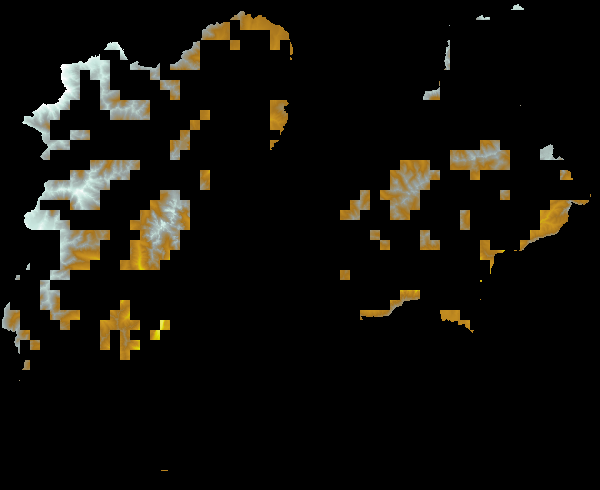

In [ ]:
# If there are holes, go back to the top :)
Image(S.relief_tiny('../dtm_local/trento2009x2_dtm.tif', 200))

⚠️ Part of the Brento area (~46.1→2,10.5) is still missing. Bounds `10.79 46.06 11 46.25`. Let's try to get it from the 2009 1x1 data, using 2x2 data to target correct tile range.

In [72]:
# longitude first!
bounds = !echo "10.79 46.06\n11 46.25" | gdaltransform -s_srs EPSG:4326 -t_srs EPSG:25832
w, s, _, e, n, _ = [round(float(x)) for x in ' '.join(bounds).split()]
w,s,e,n

(638453, 5102272, 654164, 5123769)

In [60]:
coordmap_2009 = !for f in dwn1/dtm000*.tif;  echo -n "$f\t" && gdalinfo $f | rg Origin | rg -o '[567]\d+' | tr "\n" "\t" && echo
len(coordmap_2009)

273

In [66]:
coordmap_2009[0].split('\t')

['dwn1/dtm000001_wor.tif', '713990', '5158010', '']

In [73]:
cmap09 = [(t, int(x), int(y)) for (t, x, y, _) in (s.split('\t') for s in coordmap_2009)]
cmap09[0]

('dwn1/dtm000001_wor.tif', 713990, 5158010)

In [75]:
selected = [(t, x, y) for t, x, y in cmap09 if w<x<e and s<y<n] 
selected

[('dwn1/dtm000623_wor.tif', 651990, 5122010),
 ('dwn1/dtm000675_wor.tif', 643990, 5120010),
 ('dwn1/dtm000676_wor.tif', 645990, 5120010),
 ('dwn1/dtm000730_wor.tif', 641990, 5118010),
 ('dwn1/dtm000731_wor.tif', 643990, 5118010),
 ('dwn1/dtm000732_wor.tif', 645990, 5118010),
 ('dwn1/dtm000733_wor.tif', 647990, 5118010),
 ('dwn1/dtm000784_wor.tif', 639990, 5116010),
 ('dwn1/dtm000785_wor.tif', 641990, 5116010),
 ('dwn1/dtm000786_wor.tif', 643990, 5116010),
 ('dwn1/dtm000787_wor.tif', 645990, 5116010),
 ('dwn1/dtm000788_wor.tif', 647990, 5116010),
 ('dwn1/dtm000837_wor.tif', 639990, 5114010),
 ('dwn1/dtm000838_wor.tif', 641990, 5114010),
 ('dwn1/dtm000839_wor.tif', 643990, 5114010),
 ('dwn1/dtm000840_wor.tif', 645990, 5114010),
 ('dwn1/dtm000841_wor.tif', 647990, 5114010),
 ('dwn1/dtm000891_wor.tif', 639990, 5112010),
 ('dwn1/dtm000892_wor.tif', 641990, 5112010),
 ('dwn1/dtm000893_wor.tif', 643990, 5112010),
 ('dwn1/dtm000894_wor.tif', 645990, 5112010),
 ('dwn1/dtm000944_wor.tif', 639990

In [76]:
r = 2000*5  # radius
selected = [(t, x, y) for t, x, y in cmap09 if w-r < x < e+r and s-r < y < n+r] 
selected

[('dwn1/dtm000377_wor.tif', 647990, 5132010),
 ('dwn1/dtm000421_wor.tif', 645990, 5130010),
 ('dwn1/dtm000422_wor.tif', 647990, 5130010),
 ('dwn1/dtm000468_wor.tif', 645990, 5128010),
 ('dwn1/dtm000509_wor.tif', 629990, 5126010),
 ('dwn1/dtm000510_wor.tif', 631990, 5126010),
 ('dwn1/dtm000511_wor.tif', 633990, 5126010),
 ('dwn1/dtm000512_wor.tif', 635990, 5126010),
 ('dwn1/dtm000513_wor.tif', 637990, 5126010),
 ('dwn1/dtm000560_wor.tif', 629990, 5124010),
 ('dwn1/dtm000561_wor.tif', 631990, 5124010),
 ('dwn1/dtm000562_wor.tif', 633990, 5124010),
 ('dwn1/dtm000563_wor.tif', 635990, 5124010),
 ('dwn1/dtm000571_wor.tif', 651990, 5124010),
 ('dwn1/dtm000612_wor.tif', 629990, 5122010),
 ('dwn1/dtm000613_wor.tif', 631990, 5122010),
 ('dwn1/dtm000623_wor.tif', 651990, 5122010),
 ('dwn1/dtm000668_wor.tif', 629990, 5120010),
 ('dwn1/dtm000675_wor.tif', 643990, 5120010),
 ('dwn1/dtm000676_wor.tif', 645990, 5120010),
 ('dwn1/dtm000724_wor.tif', 629990, 5118010),
 ('dwn1/dtm000730_wor.tif', 641990

In [130]:
selected_n = set()
for (t, x, y) in selected:
    tile_number = int(re.findall(r'dtm(\d+)_', t)[0])
    for n in range(-10, 11):
        selected_n.add(tile_number+n)

for i in range(1, 300):  # pampeago
    selected_n.add(i)
for i in range(1010, 1300):  # south of Brento
    selected_n.add(i)

print(len(selected_n))
# ' '.join(map(str, selected_n))

938


## DTM 2009 1x1 download

In [117]:
!pwd

/home/me/code/eddy-geek/slope-ign-alti/trentino


In [131]:
rooturl2009x1 = 'https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/'

def downloadspecific(rooturl, selected=None, pattern=r'href="([^"]+)"', destdir='dwn', callback=None):
    os.makedirs(destdir, exist_ok=True)
    indexurl = urlopen(rooturl).read().decode()
    suffixes = re.findall(pattern, indexurl)
    print(len(suffixes))
    for i, suff in enumerate(suffixes, 1):
        dest = pjoin(destdir, basename(suff))
        if not exists(dest) and\
                not exists(dest.replace('asc.zip', 'tif')):  # custom lidar14 case
            tilenum = int(re.findall(r'\d+', suff)[0])
            if selected and not tilenum in selected:
                print("NO  ", tilenum, rooturl+suff)
            else: 
                try:
                    print(i, "GET ", rooturl+suff)
                    urlretrieve(rooturl+suff, dest)
                except URLError:
                    time.sleep(5)
                    urlretrieve(rooturl+suff, dest)
            if callback: callback(dest)
        else:
            print(i, "SKIP", rooturl+suff)

downloadspecific(rooturl2009x1, selected_n, pattern=r'"(dtm[^"<>]*\.tif)"', destdir='dwn3')

# ~10 minutes

1410
1 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000007_wor.tif
2 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000008_wor.tif
3 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000009_wor.tif
4 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000010_wor.tif
5 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000012_wor.tif
6 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000017_wor.tif
7 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000018_wor.tif
8 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000019_wor.tif
9 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000020_wor.tif
10 GET  https://siat.provincia.tn.it/IDT/raster/.public/lidar_2009_pat_dtm_1mX1m/dtm000021_wor.tif
11 GET  https:

In [100]:
!gdalinfo dwn3/dtm000368_wor.tif | rg -v '^     '

Driver: GTiff/GeoTIFF
Files: dwn3/dtm000368_wor.tif
Size is 2020, 2020
Origin = (629990.000000000000000,5132010.000000000000000)
Pixel Size = (1.000000000000000,-1.000000000000000)
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  629990.000, 5132010.000) 
Lower Left  (  629990.000, 5129990.000) 
Upper Right (  632010.000, 5132010.000) 
Lower Right (  632010.000, 5129990.000) 
Center      (  631000.000, 5131000.000) 
Band 1 Block=2020x1 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [104]:
!gdalinfo dwn3/dtm000385_wor.tif| rg -v '^     '

Driver: GTiff/GeoTIFF
Files: dwn3/dtm000385_wor.tif
Size is 2020, 2020
Coordinate System is:
ENGCRS["unnamed",
    EDATUM[""],
    CS[Cartesian,2],
Data axis to CRS axis mapping: 1,2
Origin = (663990.000000000000000,5132010.000000000000000)
Pixel Size = (1.000000000000000,-1.000000000000000)
Metadata:
  AREA_OR_POINT=Point
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (  663990.000, 5132010.000) 
Lower Left  (  663990.000, 5129990.000) 
Upper Right (  666010.000, 5132010.000) 
Lower Right (  666010.000, 5129990.000) 
Center      (  665000.000, 5131000.000) 
Band 1 Block=2020x1 Type=Float32, ColorInterp=Gray
  NoData Value=-9999


In [148]:
from subprocess import check_output
from itertools import groupby

def getcrs(tpath):
    # eg 'PROJCRS["ETRS_1989_UTM_Zone_32N",' or 'ENGCRS["unnamed",' or 'Origin: ...' if no CRS
    crs_line = check_output(['gdalinfo', tpath]).split(b'\n')[4]
    return crs_line if b'[' in crs_line else b''

tcrs = {tpath: getcrs(tpath) for tpath in Path('dwn3').glob('dtm*_wor.tif')}


In [159]:
set(tcrs.values())
# The projection is *not* included in the files! or worse there are randomly weird definitions

{b'',
 b'ENGCRS["unnamed",',
 b'PROJCRS["ETRS89 / UTM zone 32N",',
 b'PROJCRS["ETRS_1989_UTM_Zone_32N",'}

In [157]:
key = lambda t: tcrs[t]
tiles_by_crs = groupby(sorted(tcrs, key=key), key)
#print(len(tiles_by_crs)) #4

In [158]:
for i, (crs, tiles) in enumerate(tiles_by_crs):
    # print(i, crs, len(tiles))
    S.check_run(f"gdalbuildvrt -a_srs EPSG:25832 -overwrite trento2009x1_crs{i}_dtm.vrt " + ' '.join(map(str, tiles)))

0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.


In [144]:
tiles_by_crs

[(None, <itertools._grouper at 0x7f2e4024eac0>)]

gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 200 -200 trento2009x1none_dtm.vrt trento2009x1_dtm.vrt /tmp/tiny.tif
Creating output file that is 580P x 190L.
Processing trento2009x1none_dtm.vrt [1/2] : 0Using internal nodata values (e.g. -9999) for image trento2009x1none_dtm.vrt.
Copying nodata values from source trento2009x1none_dtm.vrt to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90.Processing trento2009x1_dtm.vrt [2/2] : Using internal nodata values (e.g. -9999) for image trento2009x1_dtm.vrt.
..100 - done.
gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


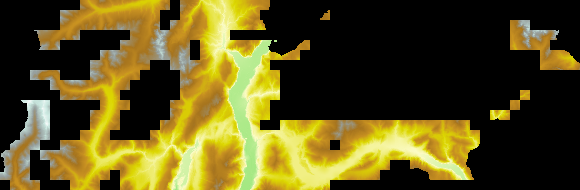

In [126]:
Image(S.relief_tiny('trento2009x1none_dtm.vrt trento2009x1_dtm.vrt', 200))

gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 200 -200 trento2009x2_dtm.vrt trento2009x1none_dtm.vrt trento2009x1_dtm.vrt /tmp/tiny.tif
Creating output file that is 600P x 490L.
Processing trento2009x2_dtm.vrt [1/3] : 0Using internal nodata values (e.g. -9999) for image trento2009x2_dtm.vrt.
Copying nodata values from source trento2009x2_dtm.vrt to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing trento2009x1none_dtm.vrt [2/3] : 0Using internal nodata values (e.g. -9999) for image trento2009x1none_dtm.vrt.
...10...20Processing trento2009x1_dtm.vrt [3/3] : Using internal nodata values (e.g. -9999) for image trento2009x1_dtm.vrt.
...30gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


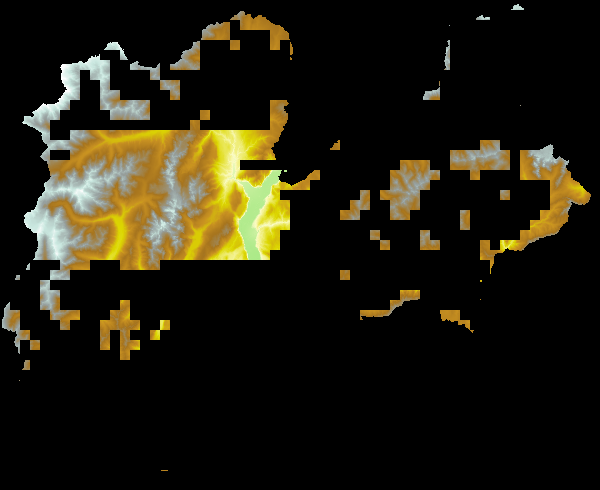

In [114]:
Image(S.relief_tiny('trento2009x2_dtm.vrt trento2009x1none_dtm.vrt trento2009x1_dtm.vrt', 200))


## Merge

In [160]:
!gdalwarp $S.DFLT_WARP_OPT -tr 1 -1 \
    trento2009x2_dtm.vrt trento2009x1_crs0_dtm.vrt trento2009x1_crs1_dtm.vrt trento2009x1_crs2_dtm.vrt \
    trento2009x1_crs3_dtm.vrt trento2011_dtm.vrt trento2012_dtm.vrt trento2014_dtm.vrt \
    ../dtm_local/trento_dtm.tif

# 40 minutes

Creating output file that is 120020P x 98510L.
Processing trento2009x2_dtm.vrt [1/8] : 0Using internal nodata values (e.g. -9999) for image trento2009x2_dtm.vrt.
Copying nodata values from source trento2009x2_dtm.vrt to destination ../dtm_local/trento_dtm.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
Processing trento2009x1_crs0_dtm.vrt [2/8] : 0Using internal nodata values (e.g. -9999) for image trento2009x1_crs0_dtm.vrt.
...10...20...30...40...50...60Processing trento2009x1_crs1_dtm.vrt [3/8] : Using internal nodata values (e.g. -9999) for image trento2009x1_crs1_dtm.vrt.
Processing trento2009x1_crs2_dtm.vrt [4/8] : Using internal nodata values (e.g. -9999) for image trento2009x1_crs2_dtm.vrt.
Processing trento2009x1_crs3_dtm.vrt [5/8] : Using internal nodata values (e.g. -9999) for image trento2009x1_crs3_dtm.vrt.
Processing trento2011_dtm.vrt [6/8] : Using internal nodata values (e.g. -9999) for image trento2011_dtm.vrt.
Processing trento2012_dtm.vrt [7/8] : Proc

In [163]:
#!gdaldem slope $S.DFLT_OPT ../dtm_local/trento_dtm.tif ../slope_local/trento_slope.tif

0...10...20...30...40...50...60...70...80...90...100 - done.


gdalwarp -overwrite -multi -wo NUM_THREADS=ALL_CPUS  -tr 100 -100 ../dtm_local/trento_dtm.tif /tmp/tiny.tif
Creating output file that is 1200P x 985L.
Processing ../dtm_local/trento_dtm.tif [1/1] : 0Using internal nodata values (e.g. -9999) for image ../dtm_local/trento_dtm.tif.
Copying nodata values from source ../dtm_local/trento_dtm.tif to destination /tmp/tiny.tif.
...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...gdaldem color-relief /tmp/tiny.tif ~/code/eddy-geek/TIL/geo/data/gdaldem-relief9.clr /tmp/tiny_relief.png
0...10...20...30...40...50...60...70...80...90...100 - done.


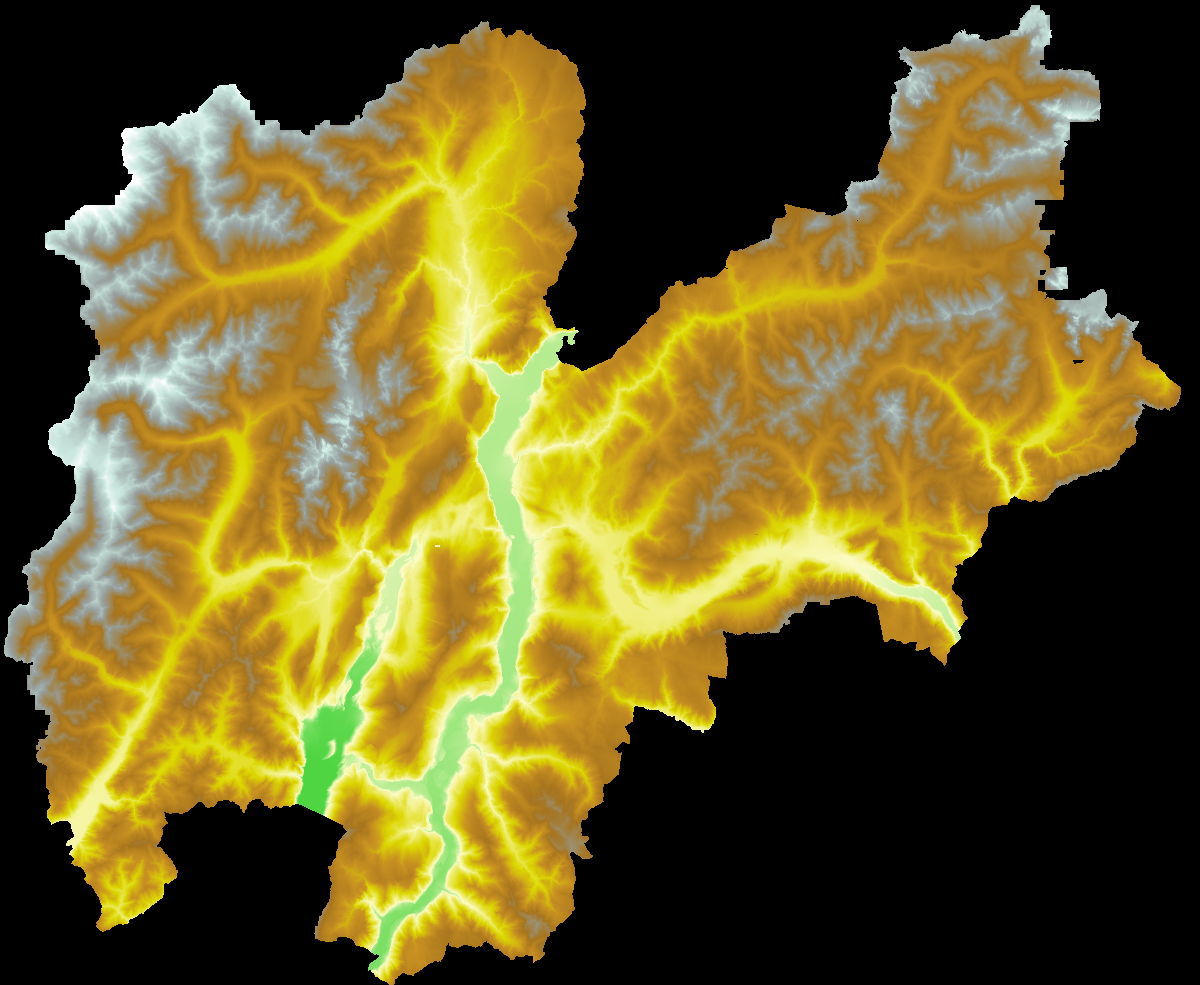

In [161]:
Image(S.relief_tiny('../dtm_local/trento_dtm.tif', 100))

## Cloud backup

In [166]:
!command -v aws && \
    aws s3 cp --acl public-read ../dtm_local/trento_dtm.tif s3://dtmlocal/

/ything/software/anaconda3/bin/aws
upload: ../dtm_local/trento_dtm.tif to s3://dtmlocal/trento_dtm.tif


In [165]:
!pwd

/home/me/code/eddy-geek/slope-ign-alti/trentino
